In [1]:
from src.geojson import build_geojson_feature_collection
from src.cluster_stats import Stats
from src.dataframes.geohash_taxa_counts import GeohashTaxaCountsDataFrame
from src.render import plot_clusters
from src.geojson import build_geojson_feature_collection
import logging
from run import cluster
import polars as pl


In [2]:
# Inputs
input_file = "data-north-america-us-ca-mx.csv"
geohash_precision = 3
show_dendrogram = True
log_file = "log.txt"
output_file = "output.geojson"
num_clusters = 8
use_cache = False
plot = True

In [3]:
# set up logging
logging.basicConfig(filename=log_file, encoding="utf-8", level=logging.INFO)


In [4]:
geohash_taxa_counts_dataframe = GeohashTaxaCountsDataFrame.build(
    input_file, geohash_precision
)

In [5]:
geohash_taxa_counts_dataframe.df

geohash,kingdom,rank,name,count
str,enum,enum,str,u32
"""97q""","""Plantae""","""species""","""Aristolochia watsonii""",8
"""97q""","""Animalia""","""family""","""Strigidae""",9
"""97q""","""Animalia""","""family""","""Sphingidae""",7
"""97q""","""Plantae""","""species""","""Brickellia peninsularis""",4
"""97q""","""Animalia""","""family""","""Aeolidiidae""",4
…,…,…,…,…
"""zcq""","""Plantae""","""species""","""Galium aparine""",1
"""zcq""","""Plantae""","""order""","""Dipsacales""",1
"""zcq""","""Plantae""","""species""","""Leptarrhena pyrolifolia""",1


/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/sklearn/decomposition/_incremental_pca.py:376: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


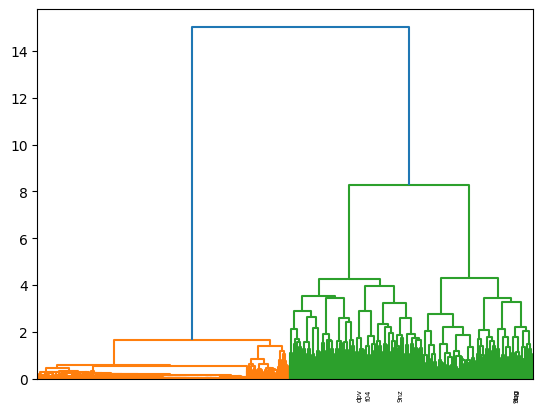

In [6]:

cluster_index = cluster.run(
    geohash_taxa_counts_dataframe,
    num_clusters,
    show_dendrogram,
    use_cache,
)

In [7]:
# Exclude the Aleutian Islands
# cluster_index.df = cluster_index.df.filter(pl.col("geohash").str.starts_with("z").not_())

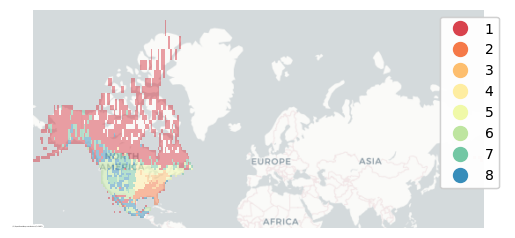

In [8]:
from src.dataframes.cluster_color import ClusterColorDataFrame

# Find the top averages of taxon
all_stats = Stats.build(geohash_taxa_counts_dataframe)

cluster_colors = ClusterColorDataFrame.from_clusters(cluster_index.cluster_ids())

feature_collection = build_geojson_feature_collection(
    cluster_index,
    cluster_colors,
)

# print_results(darwin_core_aggregations, all_stats, cluster_dataframe)

from run import write_geojson
write_geojson(feature_collection, output_file)

plot_clusters(feature_collection)

# write_geojson(feature_collection, args.output_file)

In [9]:
from src.html_output import build_html_output
from IPython.display import display, HTML

html = build_html_output(
    geohash_taxa_counts_dataframe,
    cluster_index,
    cluster_colors,
    all_stats,
)

display(HTML(html))


In [10]:
from scipy.spatial import distance
from src.cluster import build_condensed_distance_matrix

condensed_distance_matrix = build_condensed_distance_matrix(
    geohash_taxa_counts_dataframe,
    use_cache,
)

clusters = cluster_index.df.sort(by=pl.col("geohash"))["cluster"]

from sklearn.manifold import TSNE

square_distance_matrix = distance.squareform(condensed_distance_matrix)

tsne = TSNE(
    n_components=2,
    random_state=42,
    metric="precomputed",
    init="random",
)
X_tsne = tsne.fit_transform(square_distance_matrix)
tsne.kl_divergence_


/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/sklearn/decomposition/_incremental_pca.py:376: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1.3161671161651611

/var/folders/_w/vytm69g55mv9csjy701xgszr0000gn/T/ipykernel_69928/384326387.py:3: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.scatterplot(


<Axes: >

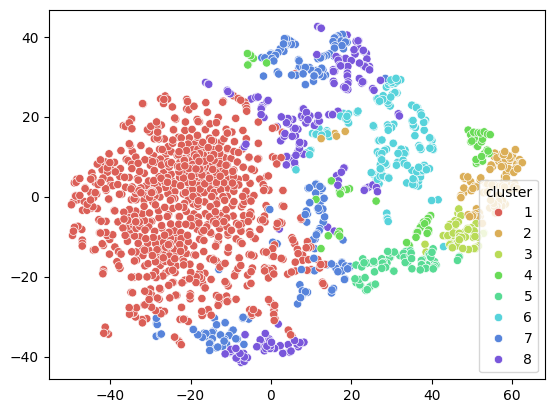

In [13]:
import seaborn as sns

sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=cluster_index.df["cluster"],
    palette=sns.color_palette("hls", 10),
    alpha=1,
)

In [69]:
notable_species = set()

for (cluster, geohashes) in cluster_index.iter_clusters_and_geohashes():
    stats = Stats.build(
        geohash_taxa_counts_dataframe,
        geohash_filter=geohashes,
    )
    for kingdom, species, count in (
        stats.taxon.sort(by="count", descending=True)
        .limit(10)
        .select(["kingdom", "species", "count"])
        .collect()
        .iter_rows(named=False)
    ):
        average = (
            stats.taxon.filter(
                pl.col("kingdom") == kingdom, pl.col("species") == species
            )
            .collect()
            .get_column("average")
            .item()
        )
        all_average = (
            all_stats.taxon.filter(
                pl.col("kingdom") == kingdom, pl.col("species") == species
            )
            .collect()
            .get_column("average")
            .item()
        )

        # If the difference between the average of the cluster and the average of all is greater than 50%, then it is notable
        percent_diff = (average / all_average * 100) - 100
        if abs(percent_diff) > 50:
            notable_species.add(species)

notable_species

{'Achillea millefolium',
 'Alces alces',
 'Anaxyrus americanus',
 'Anaxyrus woodhousii',
 'Anolis carolinensis',
 'Anolis sagrei',
 'Antilocapra americana',
 'Ardea alba',
 'Asclepias syriaca',
 'Bombus impatiens',
 'Branta canadensis',
 'Buteo jamaicensis',
 'Cardinalis cardinalis',
 'Chamaenerion angustifolium',
 'Chamaenerion latifolium',
 'Cornus canadensis',
 'Corvus corax',
 'Danaus plexippus',
 'Dione vanillae',
 'Haemorhous mexicanus',
 'Haliaeetus leucocephalus',
 'Harmonia axyridis',
 'Larrea tridentata',
 'Larus smithsonianus',
 'Mimus polyglottos',
 'Monotropa uniflora',
 'Odocoileus hemionus',
 'Odocoileus virginianus',
 'Opuntia polyacantha',
 'Pinus strobus',
 'Pituophis catenifer',
 'Rangifer tarandus',
 'Rhododendron groenlandicum',
 'Rubus chamaemorus',
 'Sceloporus occidentalis',
 'Sciurus carolinensis',
 'Thamnophis sirtalis',
 'Turdus migratorius',
 'Ursus americanus',
 'Ursus arctos',
 'Uta stansburiana',
 'Vaccinium vitis-idaea',
 'Zonotrichia leucophrys'}

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
from scipy.cluster.hierarchy import linkage

linkage_array = linkage(condensed_distance_matrix, "ward")

ordered_geohashes = geohash_taxa_counts_dataframe.ordered_geohashes()

def min_max_normalize(series: pl.Series) -> pl.Series:
    return (series - series.min()) / (series.max() - series.min())

col_colors = []
for geohash in ordered_geohashes:
    cluster = cluster_index.cluster_for_geohash(geohash)
    col_colors.append(cluster_colors.get_color_for_cluster(cluster))

data = {}
for species in sorted(notable_species):
    counts = []

    for geohash in ordered_geohashes:
        geohash_counts_species = geohash_taxa_counts_dataframe.df.filter(
            pl.col("geohash") == geohash, pl.col("name") == species
        ).get_column("count").sum()
        geohash_counts_all = geohash_taxa_counts_dataframe.df.filter(
            pl.col("geohash") == geohash
        ).get_column("count").sum()
        geohash_average = geohash_counts_species / geohash_counts_all
        all_average = (
            all_stats.taxon.filter(
                # TODO: Add kingdom in filter
                pl.col("species") == species
            )
            .collect()
            .get_column("average")
            .item()
        )
        counts.append(geohash_average - all_average)
    counts = pl.Series(
        values=counts,
        name=species,
    )
    # counts = counts / counts.max()
    # counts = counts.pow(1 / 3)
    data[species] = min_max_normalize(counts)


TypeError: object of type 'NoneType' has no len()

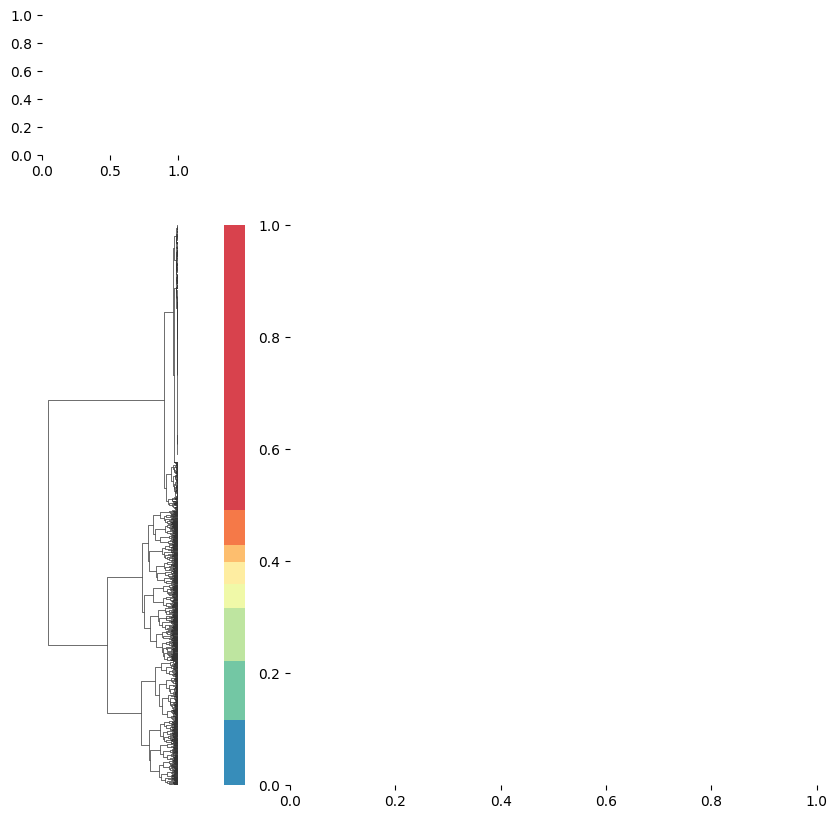

In [ ]:
dataframe = pl.DataFrame(data=data)
sns.clustermap(
    data=dataframe,
    col_cluster=False,
    row_cluster=True,
    row_linkage=linkage_array,
    row_colors=col_colors,
    xticklabels=dataframe.columns,
    yticklabels=False,
)